In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install ipython-autotime
%load_ext autotime

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
time: 578 µs (started: 2024-08-17 08:41:50 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 19.4 s (started: 2024-08-17 08:41:50 +00:00)


In [ ]:
from google.colab import files
import os
import shutil

os.makedirs('/content/data', exist_ok=True)

# Copy the data files from Google Drive to Colab
shutil.copy('/content/drive/MyDrive/THESIS/classifiers/data/data_p9_preprocessed.csv', '/content/data/data_p9_preprocessed.csv')

# Copy scripts from Google Drive to Colab
shutil.copy('/content/drive/MyDrive/THESIS/classifiers/scripts/feature_selectors.py', '/content/feature_selectors.py')
shutil.copy('/content/drive/MyDrive/THESIS/classifiers/scripts/random_forest_classifier.py', '/content/random_forest_classifier.py')
shutil.copy('/content/drive/MyDrive/THESIS/classifiers/scripts/utils_rfe.py', '/content/utils.py')

'/content/utils.py'

time: 13.3 s (started: 2024-08-17 08:42:09 +00:00)


# Error (recording) condition Random Forest classifier

As the classification using the audio source only is quite poor using the MLP still, we wish to test if using a random forest classifier would improve the performance of the classifier.

In [ ]:
# Example of calling the function
DATA_FILE = 'data/data_p9_preprocessed.csv'
RANDOM_STATE = 42

from random_forest_classifier import train_random_forest, evaluate_random_forest
from utils import prepare_data, plot_confusion_matrix, standardize_x_data, remove_specified_conditions
from sklearn.model_selection import train_test_split

time: 4.26 s (started: 2024-08-17 08:42:23 +00:00)


In [ ]:
import json

# Function to load results from the JSON file
def load_results(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            return json.load(file)
    return {'num_features': [], 'feature_names': [], 'f1_score': [], 'classification_report': [], 'confusion_matrix': []}

# Function to append results to the JSON file
def append_results(file_path, results):
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            existing_results = json.load(file)
        for key in results:
            existing_results[key].extend(results[key])
        results = existing_results
    with open(file_path, 'w') as file:
        json.dump(results, file)


time: 2.1 ms (started: 2024-08-17 10:24:39 +00:00)


In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

def plot_results(results_file_path, class_names, algorithm):
    final_results = load_results(results_file_path)
    results_df = pd.DataFrame(final_results)

    accuracy_list = []

    # Iterate over each classification report in the DataFrame
    for report in results_df['classification_report']:
        # Extract the accuracy
        match = re.search(r'accuracy\s+([\d.]+)', report)
        if match:
            accuracy_list.append(float(match.group(1)))
        else:
            accuracy_list.append(None)

    results_df['accuracy'] = accuracy_list

    best_idx = results_df['accuracy'].idxmax()
    best_num_features = results_df.loc[best_idx, 'num_features']
    best_accuracy = results_df.loc[best_idx, 'accuracy']
    best_class_report = results_df.loc[best_idx, 'classification_report']
    best_conf_matrix = results_df.loc[best_idx, 'confusion_matrix']

    print(f"Best number of features: {best_num_features}")
    print(f"Best Accuracy: {best_accuracy}")
    print("Best Classification Report:")
    print(best_class_report)

    plot_confusion_matrix(best_conf_matrix, class_names=class_names)

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['num_features'], results_df['accuracy'], marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Number of Features: {algorithm}')
    plt.grid(True)
    plt.show()

time: 2.79 ms (started: 2024-08-17 08:42:28 +00:00)


In [ ]:
def plot_results_for_num_features(results_file_path, class_names, algorithm, num=4):
    final_results = load_results(results_file_path)
    results_df = pd.DataFrame(final_results)

    accuracy_list = []

    for report in results_df['classification_report']:
        match = re.search(r'accuracy\s+([\d.]+)', report)
        if match:
            accuracy_list.append(float(match.group(1)))
        else:
            accuracy_list.append(None)

    results_df['accuracy'] = accuracy_list

    # Find the result for 5 features
    five_features_df = results_df[results_df['num_features'] == num]

    if five_features_df.empty:
        print("No results found for 5 features.")
        return

    results = five_features_df.iloc[0]
    accuracy = results['accuracy']
    class_report = results['classification_report']
    conf_matrix = results['confusion_matrix']
    features_names = results['feature_names']

    print(f"Number of features: {num}")
    print("Selected Features:")
    print(features_names)
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(class_report)

    plot_confusion_matrix(conf_matrix, class_names=class_names)


time: 1.9 ms (started: 2024-08-17 10:23:26 +00:00)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def evaluate_features_rfe(data_file, conditions_to_remove, modalities, results_file_path, start_num_features=4, max_num_features=7, random_state=42, test_size=0.2):
    # Load existing results
    results = load_results(results_file_path)

    start_num_features = max(results['num_features']) + 1 if results.get('num_features') else start_num_features

    for num_features in range(start_num_features, max_num_features + 1):
        print(f"Testing with {num_features} features")

        x, y, selected_features = prepare_data(
            data_file,
            audio_source='computer',
            classify='recording_condition',
            feature_selection=7,
            algorithm='rf',
            num_features=num_features,
            modalities=modalities,
            conditions_to_remove=conditions_to_remove,
            column_name='recording_condition'
        )
        class_names = y.unique()

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

        pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=random_state)
        f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

        print(f"F1 Score: {f1}")
        print(f"Classification Report:\n{class_report}")

        new_results = {
            'num_features': [num_features],
            'feature_names': [selected_features.tolist()],
            'f1_score': [f1],
            'classification_report': [class_report],
            'confusion_matrix': [conf_matrix.tolist()]
        }

        append_results(results_file_path, new_results)

    return class_names


time: 3.14 ms (started: 2024-08-17 12:15:40 +00:00)


# 5. Separating classification task into 4-way tasks

## Posture.

All audio features

In [ ]:
conditions_to_remove = ['high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio']

#prepare data
x, y = prepare_data(DATA_FILE, audio_source='computer', classify='recording_condition', modalities=modalities, conditions_to_remove=conditions_to_remove, column_name='recording_condition')

class_names=y.unique()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#train and evaluate the model
pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=RANDOM_STATE)
f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

print("f1 score: ", f1)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(conf_matrix, class_names=class_names)

RFE loop through 4-11 features

In [ ]:
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_posture_rf_results_p9.json'
conditions_to_remove = ['high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio']

class_names = evaluate_features_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    results_file_path=results_file_path,
    start_num_features=4,
    max_num_features=11,
    random_state=RANDOM_STATE,
    test_size=0.2
)

time: 5.8 ms (started: 2024-08-17 09:17:48 +00:00)


Best number of features: 10
Best Accuracy: 0.61
Best Classification Report:
              precision    recall  f1-score   support

     correct       0.63      0.58      0.60      1683
 arched_back       0.59      0.66      0.62      1927
hunched_back       0.59      0.48      0.53      1568
    sideways       0.62      0.70      0.66      1711

    accuracy                           0.61      6889
   macro avg       0.61      0.60      0.60      6889
weighted avg       0.61      0.61      0.61      6889



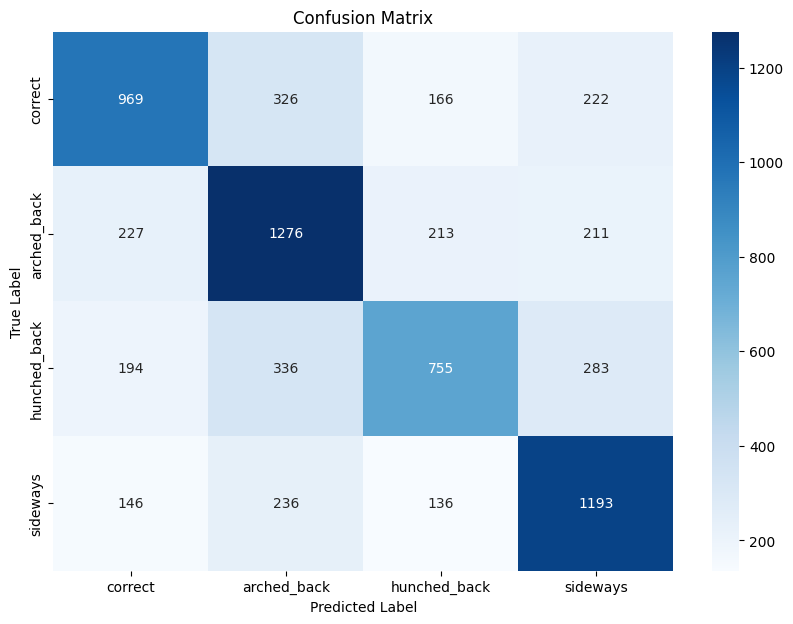

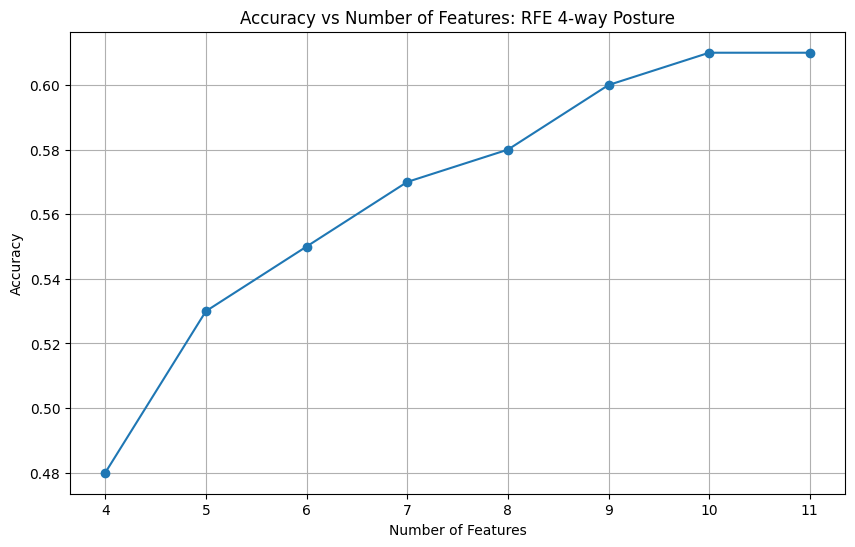

time: 692 ms (started: 2024-08-11 18:37:46 +00:00)


In [ ]:
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_posture_rf_results_p9.json'
plot_results(results_file_path=results_file_path, class_names=class_names, algorithm='RFE 4-way Posture')


Number of features: 5
Selected Features:
['computer_pitch', 'computer_spec_spread', 'computer_tristimulus3', 'computer_mfcc_1', 'computer_mfcc_3']
Accuracy: 0.53
Classification Report:
              precision    recall  f1-score   support

     correct       0.54      0.51      0.52      1683
 arched_back       0.50      0.57      0.53      1927
hunched_back       0.51      0.43      0.47      1568
    sideways       0.55      0.59      0.57      1711

    accuracy                           0.53      6889
   macro avg       0.53      0.52      0.52      6889
weighted avg       0.53      0.53      0.52      6889



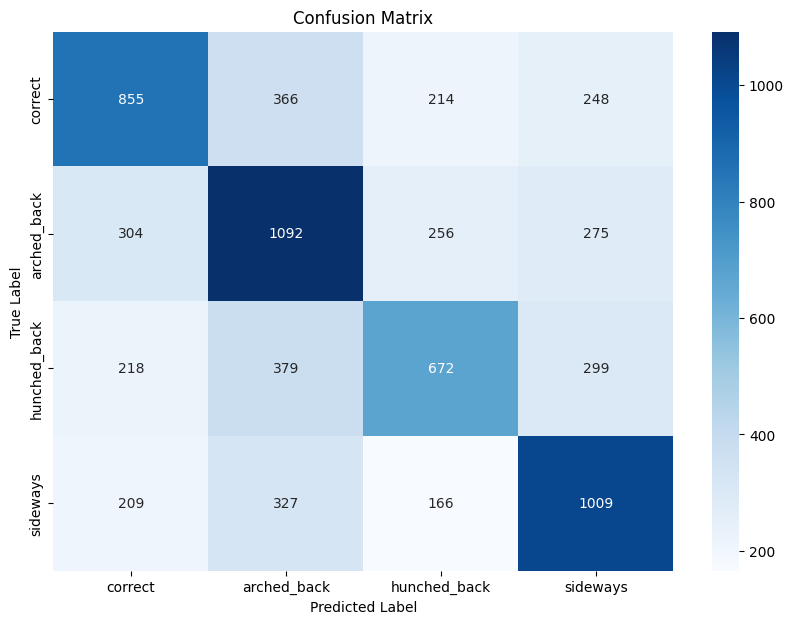

time: 325 ms (started: 2024-08-17 08:56:00 +00:00)


In [ ]:
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_posture_rf_results_p9.json'
plot_results_for_num_features(results_file_path=results_file_path, class_names=class_names, algorithm='RFE 4-way Posture')

Audio or video top 5

Selected features:  Index(['computer_pose_landmark_8_y', 'computer_pose_landmark_10_y',
       'computer_pose_landmark_11_y', 'computer_pose_landmark_12_y',
       'computer_pose_landmark_13_y'],
      dtype='object')
Mean cross-validated F1 score: 0.9992742143068061
f1 score:  0.9997096821019016
Classification Report:
              precision    recall  f1-score   support

     correct       1.00      1.00      1.00      1683
 arched_back       1.00      1.00      1.00      1927
hunched_back       1.00      1.00      1.00      1568
    sideways       1.00      1.00      1.00      1711

    accuracy                           1.00      6889
   macro avg       1.00      1.00      1.00      6889
weighted avg       1.00      1.00      1.00      6889



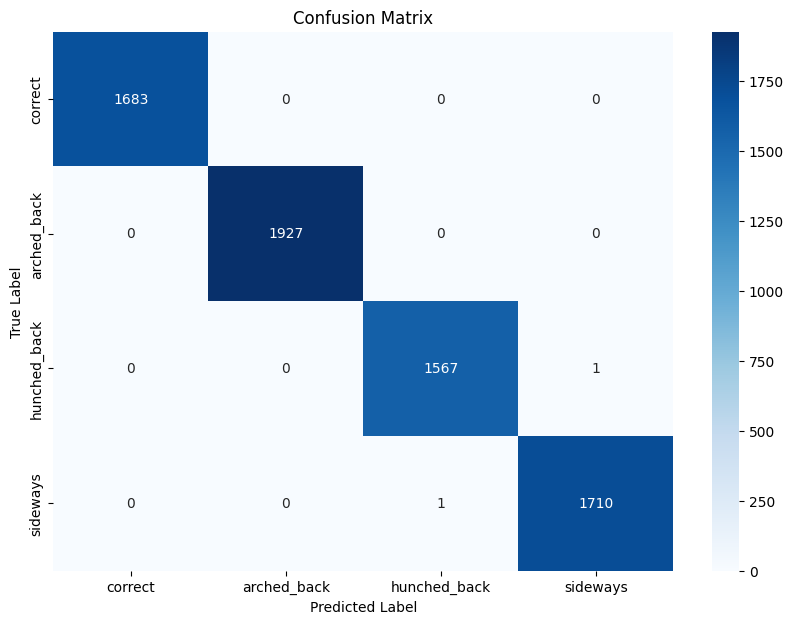

time: 1min 2s (started: 2024-08-10 13:54:13 +00:00)


In [ ]:
conditions_to_remove = ['high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio', 'video']

#prepare data
x, y = prepare_data(DATA_FILE, audio_source='computer', classify='recording_condition', num_features=5, modalities=modalities, conditions_to_remove=conditions_to_remove, column_name='recording_condition')

class_names=y.unique()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#train and evaluate the model
pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=RANDOM_STATE)
f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

print("f1 score: ", f1)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(conf_matrix, class_names=class_names)

Audio or video, all features

Mean cross-validated F1 score: 0.9998911032686697
f1 score:  1.0
Classification Report:
              precision    recall  f1-score   support

     correct       1.00      1.00      1.00      1683
 arched_back       1.00      1.00      1.00      1927
hunched_back       1.00      1.00      1.00      1568
    sideways       1.00      1.00      1.00      1711

    accuracy                           1.00      6889
   macro avg       1.00      1.00      1.00      6889
weighted avg       1.00      1.00      1.00      6889



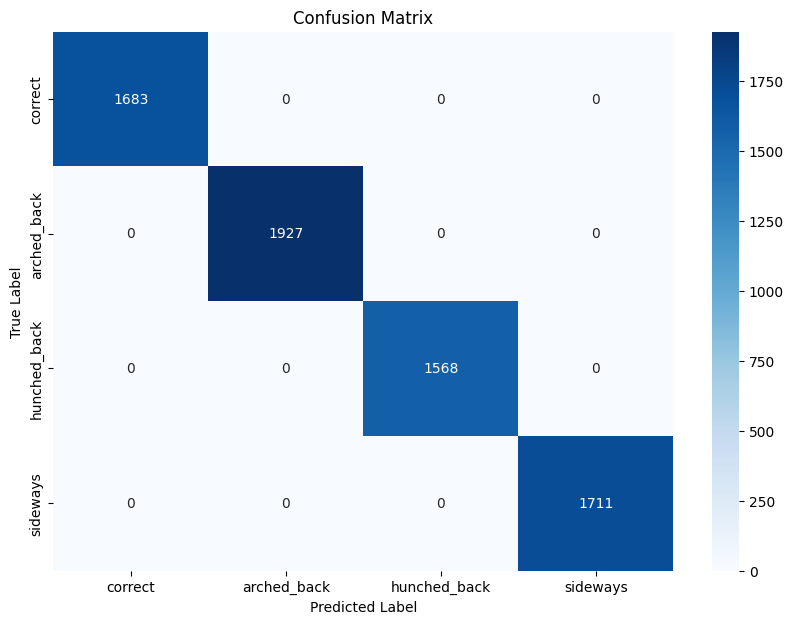

time: 3min 15s (started: 2024-08-10 13:55:16 +00:00)


In [ ]:
conditions_to_remove = ['high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio', 'video']

#prepare data
x, y = prepare_data(DATA_FILE, audio_source='computer', classify='recording_condition', modalities=modalities, conditions_to_remove=conditions_to_remove, column_name='recording_condition')

class_names=y.unique()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#train and evaluate the model
pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=RANDOM_STATE)
f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

print("f1 score: ", f1)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(conf_matrix, class_names=class_names)

## Other error conditions

Audio only, all features

Mean cross-validated F1 score: 0.6249617793459266
f1 score:  0.6246376380217139
Classification Report:
                   precision    recall  f1-score   support

          correct       0.57      0.49      0.53      1622
  chest_breathing       0.67      0.79      0.73      1927
high_articulation       0.60      0.55      0.57      1626
 low_articulation       0.64      0.67      0.65      1701

         accuracy                           0.63      6876
        macro avg       0.62      0.62      0.62      6876
     weighted avg       0.62      0.63      0.62      6876



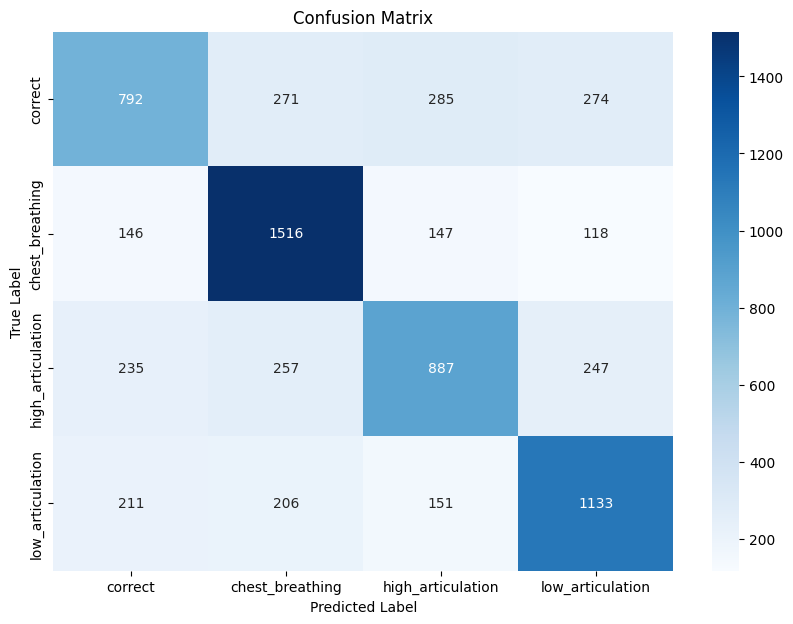

time: 5min 55s (started: 2024-08-17 10:59:35 +00:00)


In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways']
modalities = ['audio']

#prepare data
x, y, selected_features = prepare_data(DATA_FILE, audio_source='computer', classify='recording_condition', modalities=modalities, conditions_to_remove=conditions_to_remove, column_name='recording_condition')

class_names=y.unique()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#train and evaluate the model
pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=RANDOM_STATE)
f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

print("f1 score: ", f1)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(conf_matrix, class_names=class_names)

Audio 4-11 features test with RFE

In [ ]:
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_other_err_rf_results_p9.json'
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways']
modalities = ['audio']

class_names = evaluate_features_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    results_file_path=results_file_path,
    start_num_features=4,
    max_num_features=11,
    random_state=RANDOM_STATE,
    test_size=0.2
)

time: 6.38 ms (started: 2024-08-17 10:58:36 +00:00)


Best number of features: 9
Best Accuracy: 0.6
Best Classification Report:
                   precision    recall  f1-score   support

          correct       0.55      0.45      0.50      1622
  chest_breathing       0.64      0.75      0.69      1927
high_articulation       0.57      0.52      0.54      1626
 low_articulation       0.60      0.63      0.61      1701

         accuracy                           0.60      6876
        macro avg       0.59      0.59      0.59      6876
     weighted avg       0.59      0.60      0.59      6876



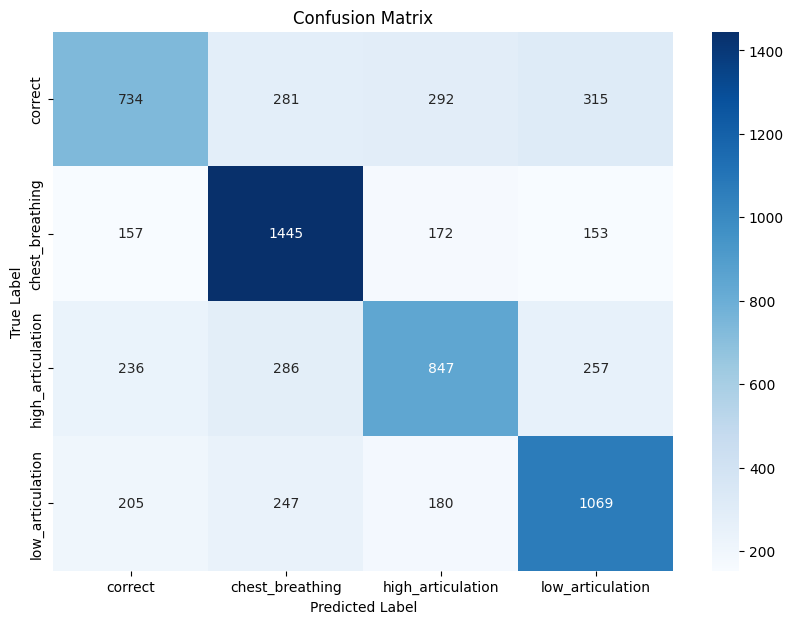

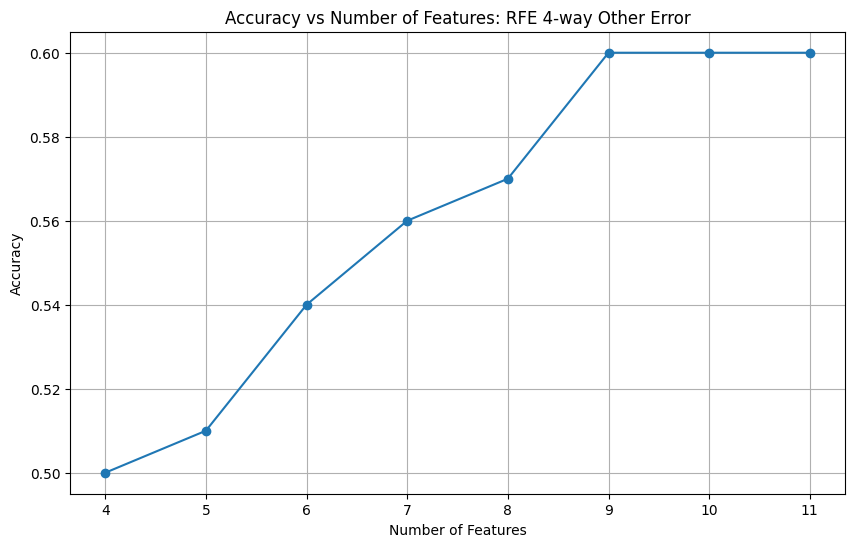

time: 1.16 s (started: 2024-08-17 11:24:40 +00:00)


In [ ]:
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_other_err_rf_results_p9.json'
plot_results(results_file_path=results_file_path, class_names=class_names, algorithm='RFE 4-way Other Error')

Number of features: 5
Selected Features:
['computer_pitch', 'computer_spec_spread', 'computer_mfcc_1', 'computer_mfcc_3', 'computer_mfcc_4']
Accuracy: 0.51
Classification Report:
                   precision    recall  f1-score   support

          correct       0.44      0.39      0.41      1622
  chest_breathing       0.56      0.66      0.61      1927
high_articulation       0.48      0.41      0.44      1626
 low_articulation       0.51      0.53      0.52      1701

         accuracy                           0.51      6876
        macro avg       0.50      0.50      0.50      6876
     weighted avg       0.50      0.51      0.50      6876



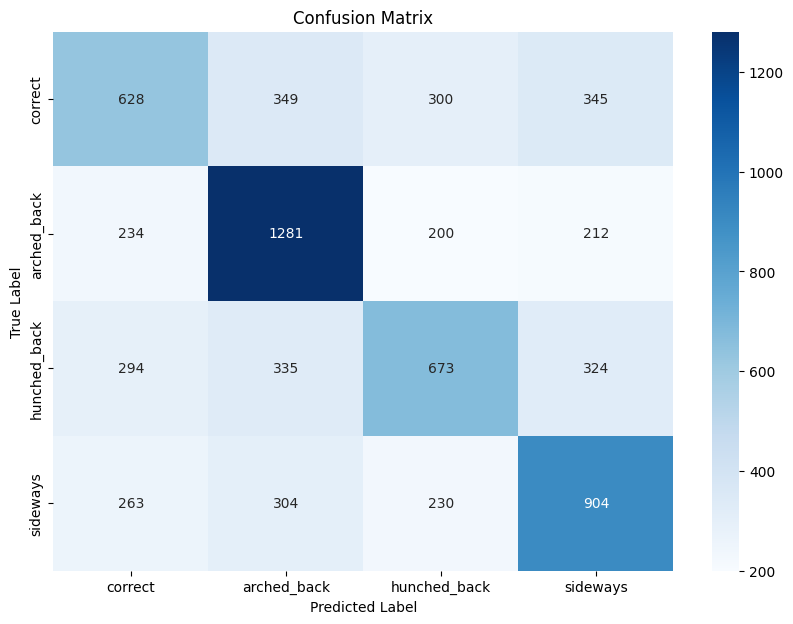

time: 1.2 s (started: 2024-08-17 08:58:15 +00:00)


In [ ]:
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_other_err_rf_results_p9.json'
plot_results_for_num_features(results_file_path=results_file_path, class_names=class_names, algorithm='RFE 4-way Posture')

Audio or video top 5

Selected features:  Index(['computer_pose_landmark_7_x', 'computer_pose_landmark_9_x',
       'computer_pose_landmark_11_y', 'computer_pose_landmark_12_y',
       'computer_pose_landmark_13_y'],
      dtype='object')
Mean cross-validated F1 score: 0.9977443839573571
f1 score:  0.9979638329935578
Classification Report:
                   precision    recall  f1-score   support

          correct       1.00      1.00      1.00      1622
  chest_breathing       1.00      1.00      1.00      1927
high_articulation       1.00      0.99      1.00      1626
 low_articulation       0.99      1.00      1.00      1701

         accuracy                           1.00      6876
        macro avg       1.00      1.00      1.00      6876
     weighted avg       1.00      1.00      1.00      6876



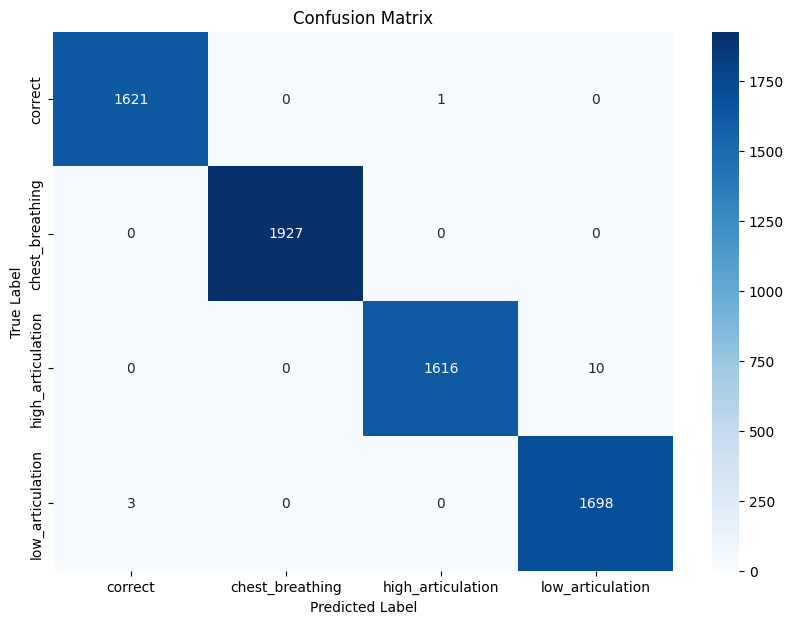

time: 1min 10s (started: 2024-08-10 14:03:53 +00:00)


In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways']
modalities = ['audio', 'video']

#prepare data
x, y, selected_features = prepare_data(DATA_FILE, audio_source='computer', classify='recording_condition', num_features=5, modalities=modalities, conditions_to_remove=conditions_to_remove, column_name='recording_condition')

class_names=y.unique()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#train and evaluate the model
pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=RANDOM_STATE)
f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

print("f1 score: ", f1)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(conf_matrix, class_names=class_names)

Audio or Video, all features

Mean cross-validated F1 score: 0.9996727333733556
f1 score:  0.9998545656094167
Classification Report:
                   precision    recall  f1-score   support

          correct       1.00      1.00      1.00      1622
  chest_breathing       1.00      1.00      1.00      1927
high_articulation       1.00      1.00      1.00      1626
 low_articulation       1.00      1.00      1.00      1701

         accuracy                           1.00      6876
        macro avg       1.00      1.00      1.00      6876
     weighted avg       1.00      1.00      1.00      6876



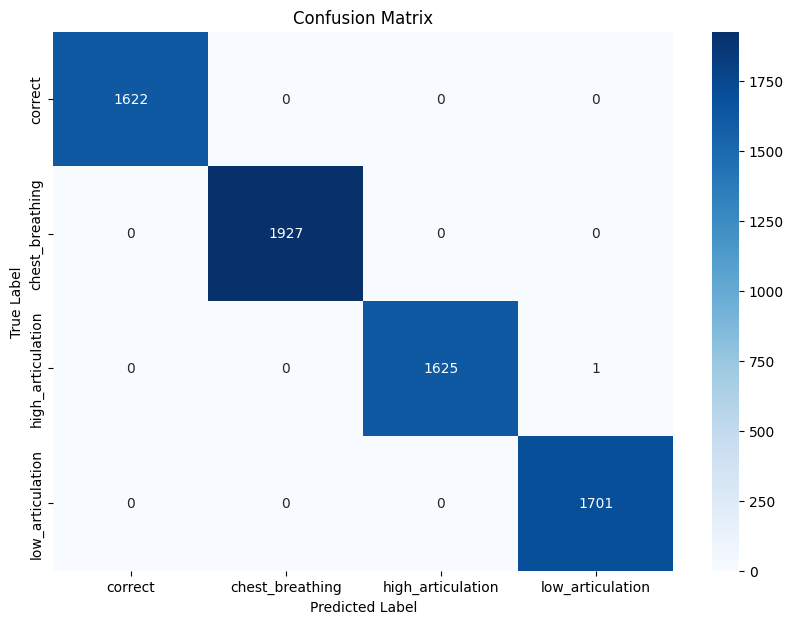

time: 3min 41s (started: 2024-08-10 14:05:04 +00:00)


In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways']
modalities = ['audio', 'video']

#prepare data
x, y, selected_features = prepare_data(DATA_FILE, audio_source='computer', classify='recording_condition', modalities=modalities, conditions_to_remove=conditions_to_remove, column_name='recording_condition')

class_names=y.unique()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#train and evaluate the model
pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=RANDOM_STATE)
f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

print("f1 score: ", f1)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(conf_matrix, class_names=class_names)

# 2-way classifiers for audio only

## Hunched Back

In [ ]:
conditions_to_remove = ['arched_back', 'sideways', 'high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio']
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_hunched_results_p9.json'

class_names = evaluate_features_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    results_file_path=results_file_path,
    start_num_features=4,
    max_num_features=9,
    random_state=RANDOM_STATE,
    test_size=0.2
)

Testing with 9 features
Selected features:  Index(['computer_pitch', 'computer_spec_slope', 'computer_tristimulus2',
       'computer_tristimulus3', 'computer_mfcc_1', 'computer_mfcc_3',
       'computer_mfcc_6', 'computer_mfcc_11', 'computer_mfcc_12'],
      dtype='object')
Mean cross-validated F1 score: 0.7595772468743034
F1 Score: 0.7716174217771106
Classification Report:
              precision    recall  f1-score   support

     correct       0.77      0.83      0.80      1927
hunched_back       0.77      0.70      0.73      1568

    accuracy                           0.77      3495
   macro avg       0.77      0.77      0.77      3495
weighted avg       0.77      0.77      0.77      3495

time: 6min (started: 2024-08-17 11:24:54 +00:00)


Best number of features: 9
Best Accuracy: 0.77
Best Classification Report:
              precision    recall  f1-score   support

     correct       0.77      0.83      0.80      1927
hunched_back       0.77      0.70      0.73      1568

    accuracy                           0.77      3495
   macro avg       0.77      0.77      0.77      3495
weighted avg       0.77      0.77      0.77      3495



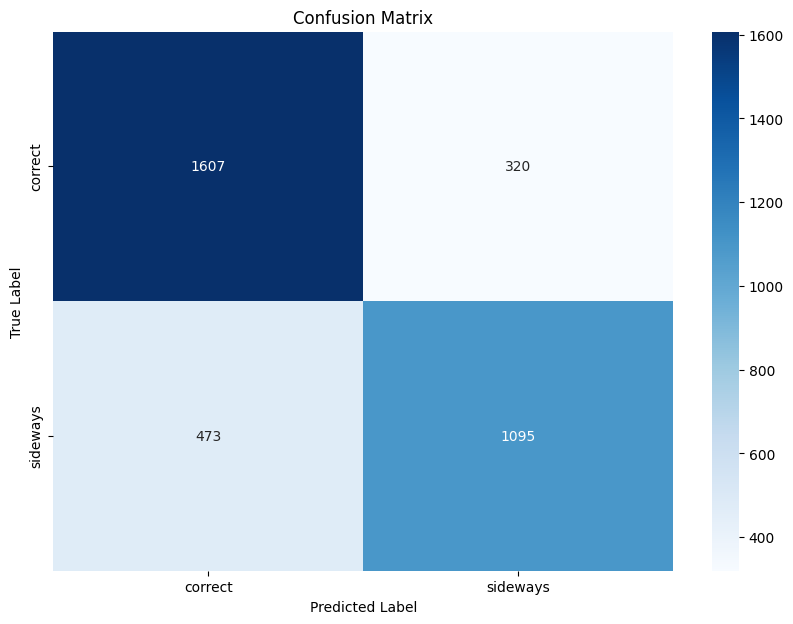

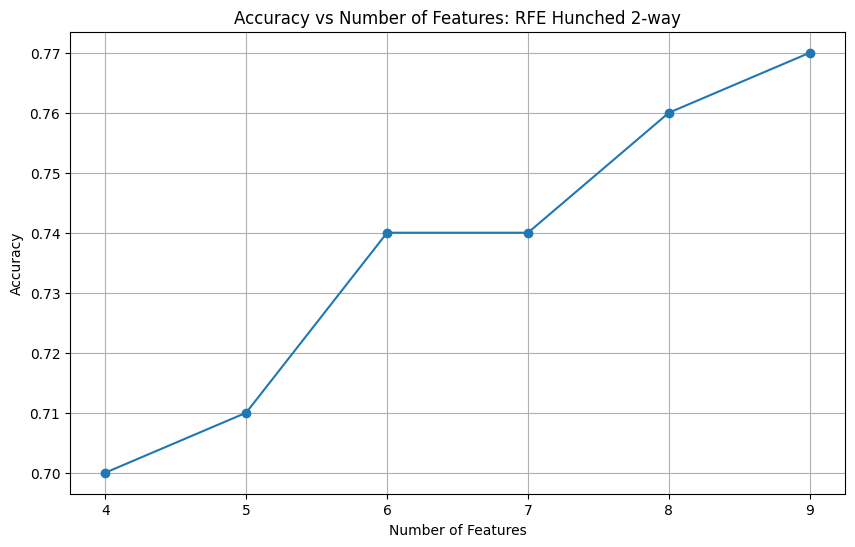

Number of features: 5
Selected Features:
['computer_pitch', 'computer_spec_spread', 'computer_tristimulus3', 'computer_mfcc_1', 'computer_mfcc_3']
Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

     correct       0.72      0.78      0.75      1927
hunched_back       0.70      0.63      0.66      1568

    accuracy                           0.71      3495
   macro avg       0.71      0.70      0.70      3495
weighted avg       0.71      0.71      0.71      3495



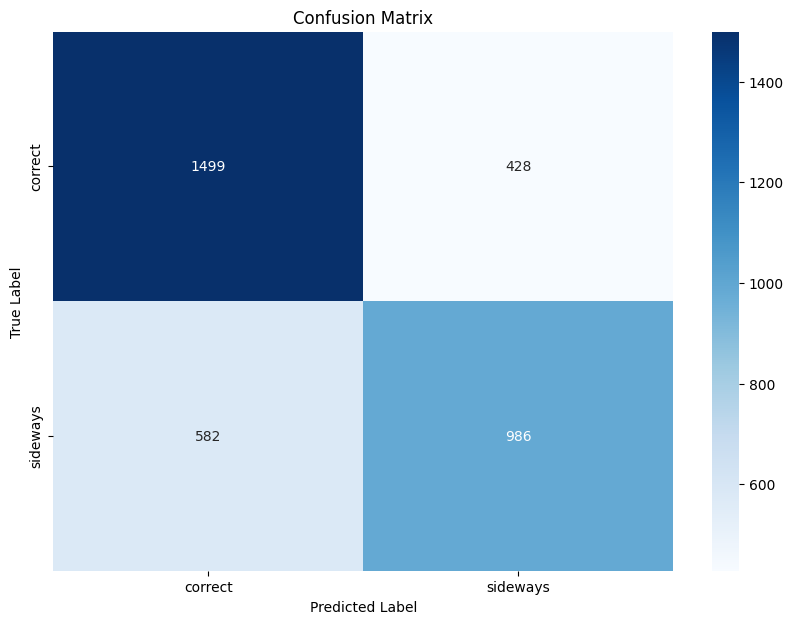

time: 868 ms (started: 2024-08-17 13:38:33 +00:00)


In [ ]:
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_hunched_results_p9.json'
plot_results(results_file_path=results_file_path, class_names=class_names, algorithm='RFE Hunched 2-way')
plot_results_for_num_features(results_file_path=results_file_path, class_names=class_names, algorithm='RFE 2-way Hunched', num=5)

## Arched Back

In [ ]:
conditions_to_remove = ['hunched_back', 'sideways', 'high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio']
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_arched_results_p9.json'

class_names = evaluate_features_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    results_file_path=results_file_path,
    start_num_features=4,
    max_num_features=8,
    random_state=RANDOM_STATE,
    test_size=0.2
)

Testing with 6 features
Selected features:  Index(['computer_pitch', 'computer_spec_spread', 'computer_tristimulus3',
       'computer_mfcc_1', 'computer_mfcc_3', 'computer_mfcc_11'],
      dtype='object')
Mean cross-validated F1 score: 0.7200053286108747
F1 Score: 0.728326448276168
Classification Report:
              precision    recall  f1-score   support

     correct       0.72      0.68      0.70      1683
 arched_back       0.73      0.77      0.75      1927

    accuracy                           0.73      3610
   macro avg       0.73      0.73      0.73      3610
weighted avg       0.73      0.73      0.73      3610

Testing with 7 features
Selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_tristimulus3',
       'computer_mfcc_1', 'computer_mfcc_2', 'computer_mfcc_3',
       'computer_mfcc_11'],
      dtype='object')
Mean cross-validated F1 score: 0.7216337184297675
F1 Score: 0.732160521900004
Classification Report:
              precision    recall 

Best number of features: 8
Best Accuracy: 0.75
Best Classification Report:
              precision    recall  f1-score   support

     correct       0.74      0.69      0.72      1683
 arched_back       0.75      0.79      0.77      1927

    accuracy                           0.75      3610
   macro avg       0.75      0.74      0.74      3610
weighted avg       0.75      0.75      0.74      3610



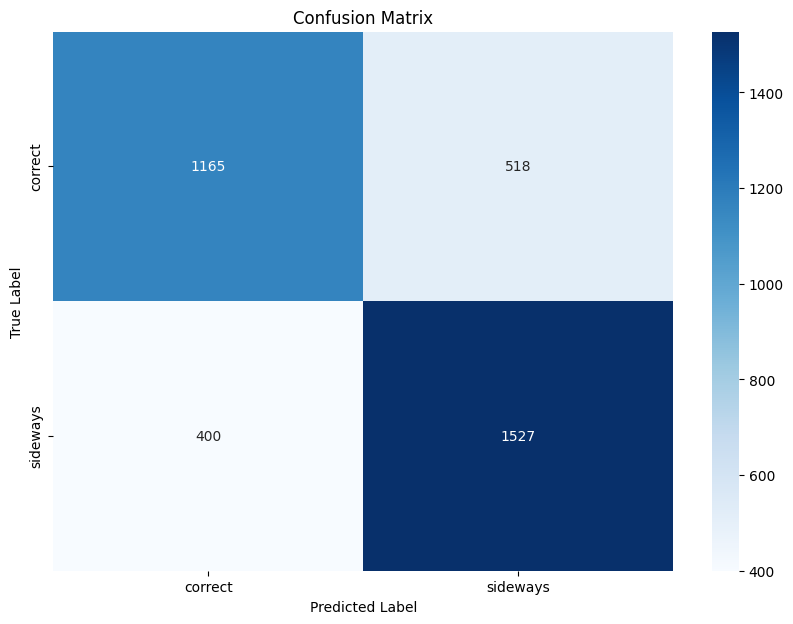

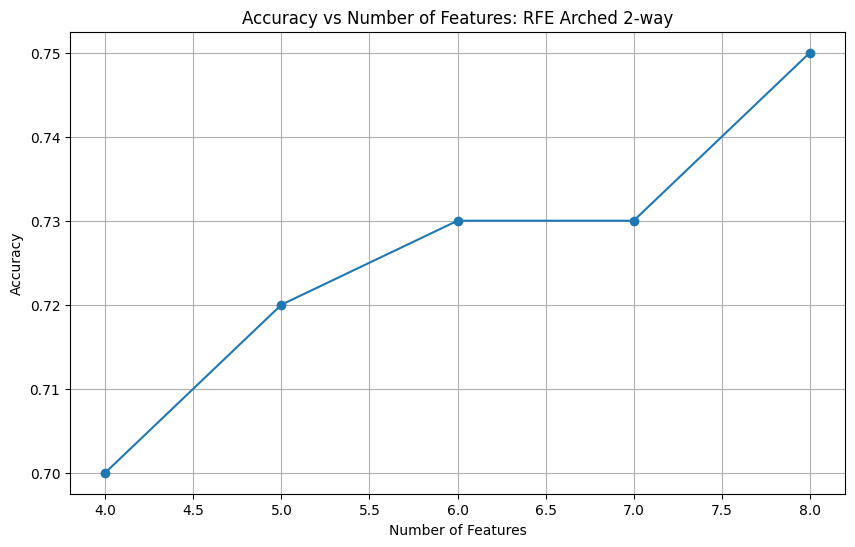

Number of features: 5
Selected Features:
['computer_pitch', 'computer_rms_energy', 'computer_tristimulus3', 'computer_mfcc_1', 'computer_mfcc_3']
Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

     correct       0.72      0.66      0.69      1683
 arched_back       0.72      0.77      0.75      1927

    accuracy                           0.72      3610
   macro avg       0.72      0.72      0.72      3610
weighted avg       0.72      0.72      0.72      3610



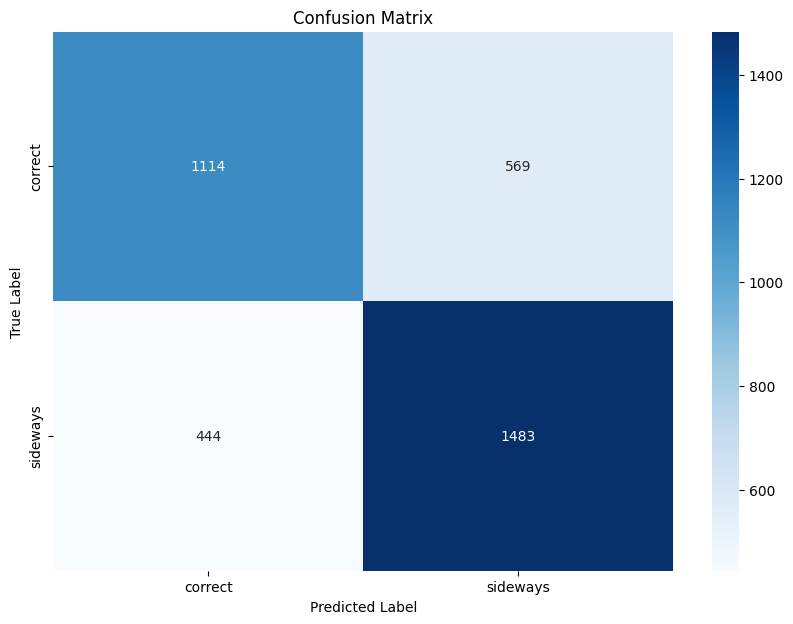

time: 837 ms (started: 2024-08-17 13:38:42 +00:00)


In [ ]:
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_arched_results_p9.json'
plot_results(results_file_path=results_file_path, class_names=class_names, algorithm='RFE Arched 2-way')
plot_results_for_num_features(results_file_path=results_file_path, class_names=class_names, algorithm='RFE 2-way Arched', num=5)

## Sideways

In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio']
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_side_results_p9.json'

class_names = evaluate_features_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    results_file_path=results_file_path,
    start_num_features=4,
    max_num_features=8,
    random_state=RANDOM_STATE,
    test_size=0.2
)

Testing with 5 features
Selected features:  Index(['computer_pitch', 'computer_spec_spread', 'computer_mfcc_3',
       'computer_mfcc_4', 'computer_mfcc_6'],
      dtype='object')
Mean cross-validated F1 score: 0.7675206212719689
F1 Score: 0.7654995144479155
Classification Report:
              precision    recall  f1-score   support

     correct       0.77      0.80      0.78      1928
    sideways       0.76      0.73      0.75      1711

    accuracy                           0.77      3639
   macro avg       0.77      0.76      0.76      3639
weighted avg       0.77      0.77      0.77      3639

Testing with 6 features
Selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1',
       'computer_mfcc_3', 'computer_mfcc_4', 'computer_mfcc_6'],
      dtype='object')
Mean cross-validated F1 score: 0.7755617783509351
F1 Score: 0.7805301529842658
Classification Report:
              precision    recall  f1-score   support

     correct       0.78      0.82   

Best number of features: 8
Best Accuracy: 0.8
Best Classification Report:
              precision    recall  f1-score   support

     correct       0.80      0.85      0.82      1928
    sideways       0.81      0.75      0.78      1711

    accuracy                           0.80      3639
   macro avg       0.81      0.80      0.80      3639
weighted avg       0.80      0.80      0.80      3639



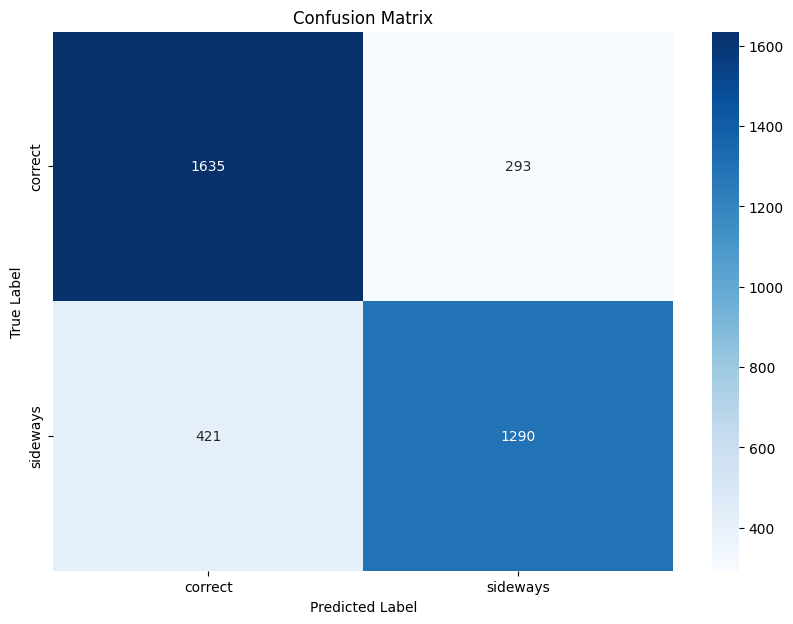

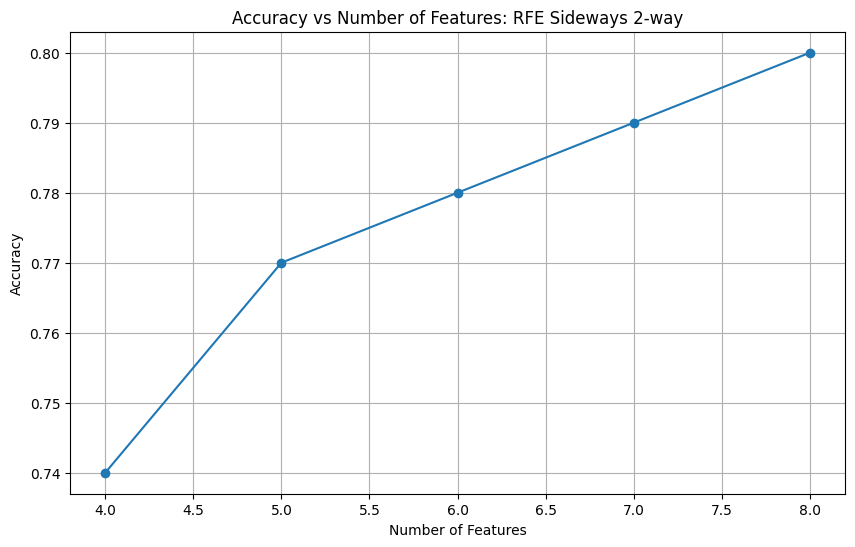

Number of features: 5
Selected Features:
['computer_pitch', 'computer_spec_spread', 'computer_mfcc_3', 'computer_mfcc_4', 'computer_mfcc_6']
Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

     correct       0.77      0.80      0.78      1928
    sideways       0.76      0.73      0.75      1711

    accuracy                           0.77      3639
   macro avg       0.77      0.76      0.76      3639
weighted avg       0.77      0.77      0.77      3639



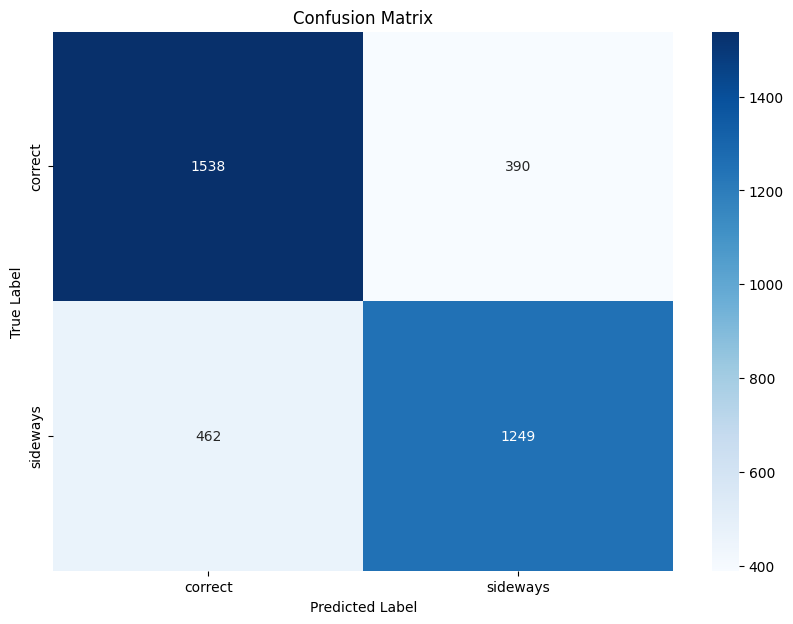

time: 1.2 s (started: 2024-08-17 13:38:52 +00:00)


In [ ]:
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_side_results_p9.json'
plot_results(results_file_path=results_file_path, class_names=class_names, algorithm='RFE Sideways 2-way')
plot_results_for_num_features(results_file_path=results_file_path, class_names=class_names, algorithm='RFE 2-way Sideways', num=5)

## High articulation

In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways', 'low_articulation', 'chest_breathing']
modalities = ['audio']
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_high_art_results_p9.json'

class_names = evaluate_features_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    results_file_path=results_file_path,
    start_num_features=4,
    max_num_features=8,
    random_state=RANDOM_STATE,
    test_size=0.2
)

Testing with 5 features
Selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1',
       'computer_mfcc_3', 'computer_mfcc_4'],
      dtype='object')
Mean cross-validated F1 score: 0.7495854494602081
F1 Score: 0.7634012738008735
Classification Report:
                   precision    recall  f1-score   support

          correct       0.76      0.82      0.79      1927
high_articulation       0.77      0.70      0.73      1626

         accuracy                           0.76      3553
        macro avg       0.77      0.76      0.76      3553
     weighted avg       0.76      0.76      0.76      3553

Testing with 6 features
Selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1',
       'computer_mfcc_3', 'computer_mfcc_4', 'computer_mfcc_8'],
      dtype='object')
Mean cross-validated F1 score: 0.7724448741580708
F1 Score: 0.789109761960599
Classification Report:
                   precision    recall  f1-score   support

   

Best number of features: 8
Best Accuracy: 0.8
Best Classification Report:
                   precision    recall  f1-score   support

          correct       0.79      0.85      0.82      1927
high_articulation       0.81      0.73      0.77      1626

         accuracy                           0.80      3553
        macro avg       0.80      0.79      0.79      3553
     weighted avg       0.80      0.80      0.80      3553



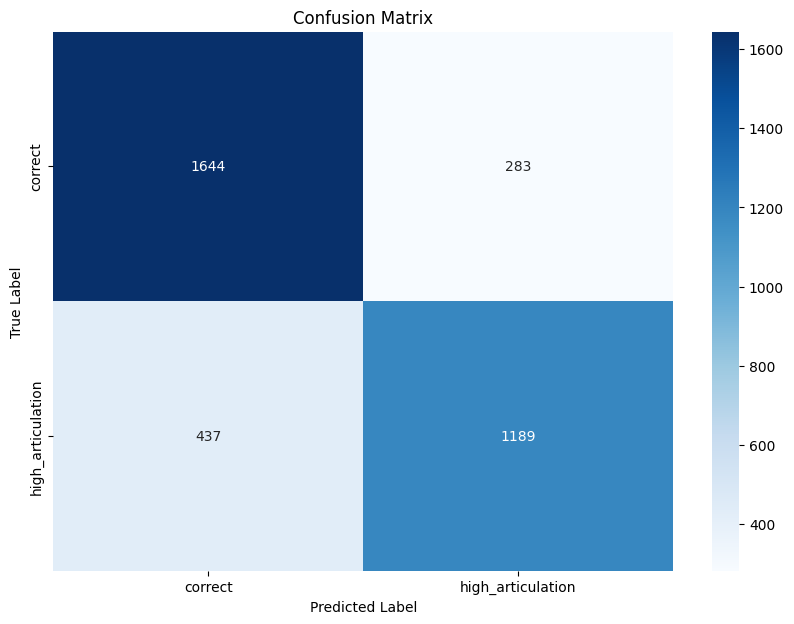

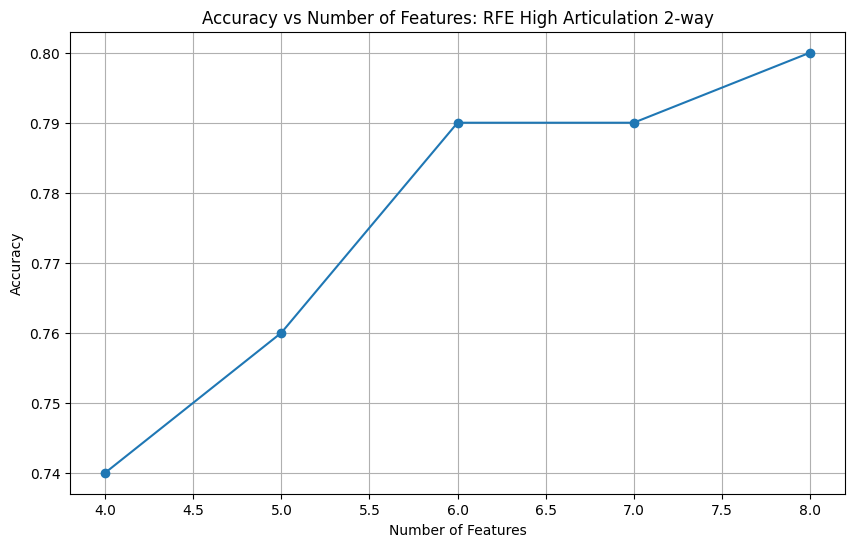

Number of features: 5
Selected Features:
['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1', 'computer_mfcc_3', 'computer_mfcc_4']
Accuracy: 0.76
Classification Report:
                   precision    recall  f1-score   support

          correct       0.76      0.82      0.79      1927
high_articulation       0.77      0.70      0.73      1626

         accuracy                           0.76      3553
        macro avg       0.77      0.76      0.76      3553
     weighted avg       0.76      0.76      0.76      3553



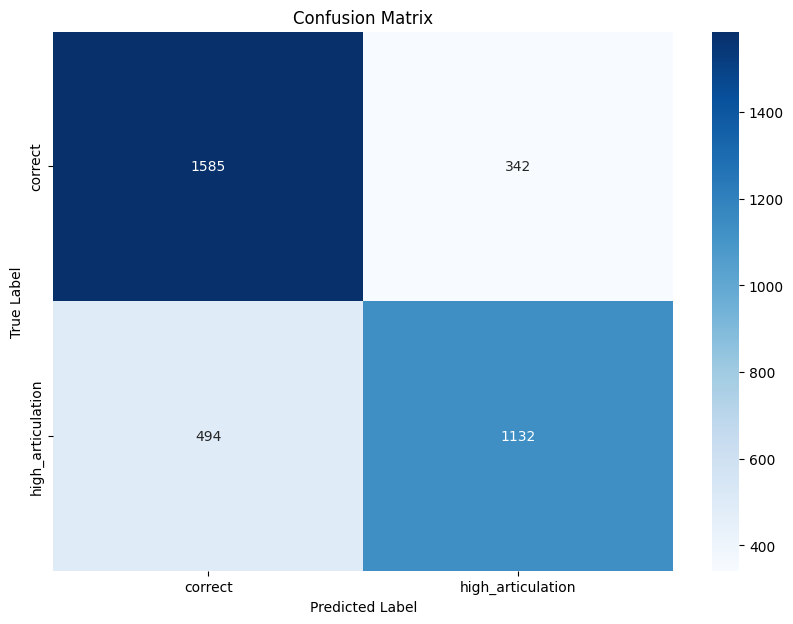

time: 1.14 s (started: 2024-08-17 14:02:49 +00:00)


In [ ]:
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_high_art_results_p9.json'
plot_results(results_file_path=results_file_path, class_names=class_names, algorithm='RFE High Articulation 2-way')
plot_results_for_num_features(results_file_path=results_file_path, class_names=class_names, algorithm='RFE 2-way High Articulation', num=5)

## Low articulation

In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways', 'high_articulation', 'chest_breathing']
modalities = ['audio']
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_low_art_results_p9.json'

class_names = evaluate_features_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    results_file_path=results_file_path,
    start_num_features=4,
    max_num_features=8,
    random_state=RANDOM_STATE,
    test_size=0.2
)

Testing with 4 features
Selected features:  Index(['computer_pitch', 'computer_spec_slope', 'computer_mfcc_3',
       'computer_mfcc_4'],
      dtype='object')
Mean cross-validated F1 score: 0.7687245146907282
F1 Score: 0.7625342355061282
Classification Report:
                  precision    recall  f1-score   support

         correct       0.77      0.79      0.78      1928
low_articulation       0.75      0.73      0.74      1701

        accuracy                           0.76      3629
       macro avg       0.76      0.76      0.76      3629
    weighted avg       0.76      0.76      0.76      3629

Testing with 5 features
Selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1',
       'computer_mfcc_3', 'computer_mfcc_4'],
      dtype='object')
Mean cross-validated F1 score: 0.77757500346789
F1 Score: 0.7699529483433755
Classification Report:
                  precision    recall  f1-score   support

         correct       0.78      0.80      0.79  

Best number of features: 8
Best Accuracy: 0.82
Best Classification Report:
                  precision    recall  f1-score   support

         correct       0.81      0.85      0.83      1928
low_articulation       0.82      0.78      0.80      1701

        accuracy                           0.82      3629
       macro avg       0.82      0.81      0.81      3629
    weighted avg       0.82      0.82      0.81      3629



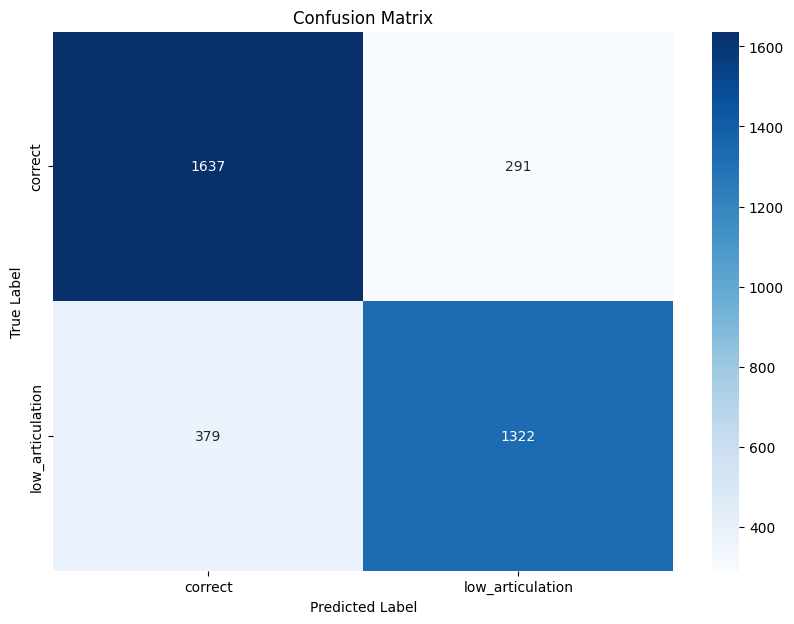

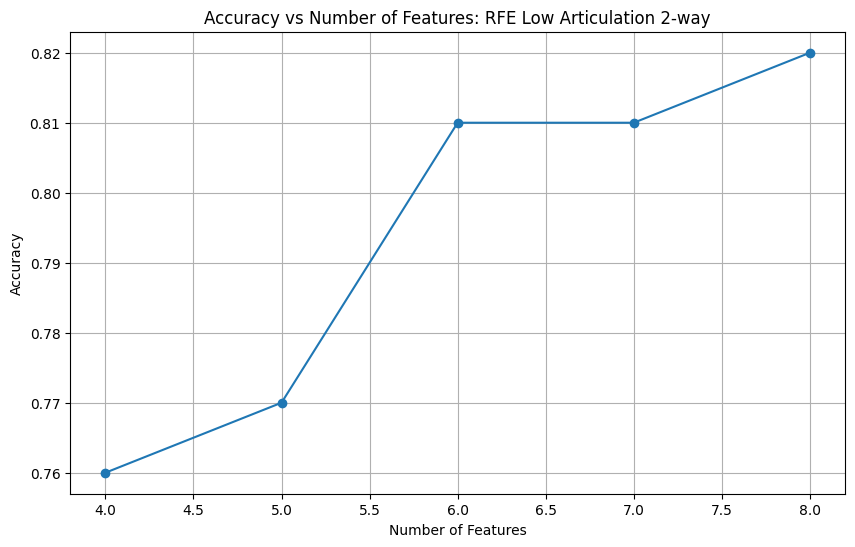

Number of features: 5
Selected Features:
['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1', 'computer_mfcc_3', 'computer_mfcc_4']
Accuracy: 0.77
Classification Report:
                  precision    recall  f1-score   support

         correct       0.78      0.80      0.79      1928
low_articulation       0.76      0.74      0.75      1701

        accuracy                           0.77      3629
       macro avg       0.77      0.77      0.77      3629
    weighted avg       0.77      0.77      0.77      3629



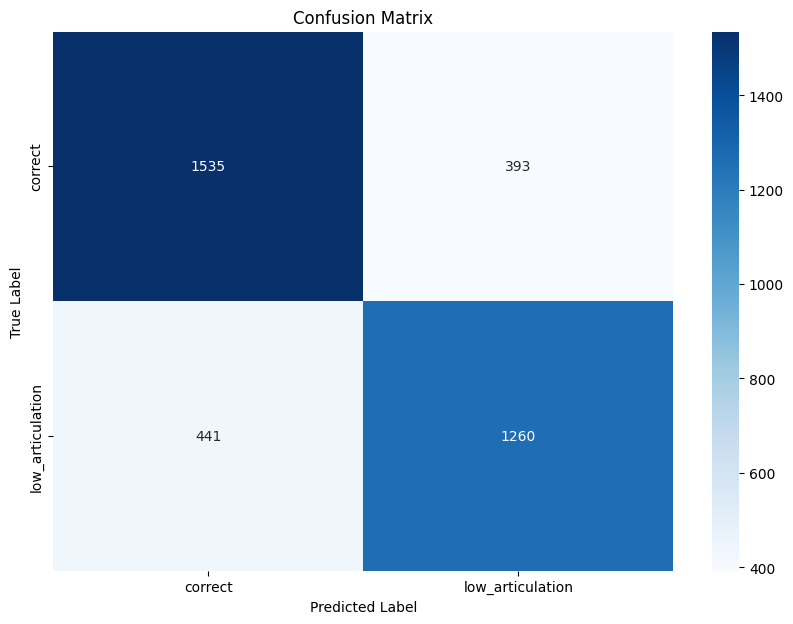

time: 1.24 s (started: 2024-08-17 14:32:39 +00:00)


In [ ]:
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_low_art_results_p9.json'
plot_results(results_file_path=results_file_path, class_names=class_names, algorithm='RFE Low Articulation 2-way')
plot_results_for_num_features(results_file_path=results_file_path, class_names=class_names, algorithm='RFE 2-way Low Articulation', num=5)

## Chest Breathing

In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways', 'high_articulation', 'low_articulation']
modalities = ['audio']
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_chest_results_p9.json'

class_names = evaluate_features_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    results_file_path=results_file_path,
    start_num_features=4,
    max_num_features=8,
    random_state=RANDOM_STATE,
    test_size=0.2
)

Testing with 5 features
Selected features:  Index(['computer_pitch', 'computer_spec_slope', 'computer_tristimulus3',
       'computer_mfcc_3', 'computer_mfcc_4'],
      dtype='object')
Mean cross-validated F1 score: 0.7558490635787151
F1 Score: 0.7635440132300622
Classification Report:
                 precision    recall  f1-score   support

        correct       0.75      0.72      0.74      1622
chest_breathing       0.77      0.80      0.79      1928

       accuracy                           0.76      3550
      macro avg       0.76      0.76      0.76      3550
   weighted avg       0.76      0.76      0.76      3550

Testing with 6 features
Selected features:  Index(['computer_pitch', 'computer_spec_slope', 'computer_tristimulus3',
       'computer_mfcc_1', 'computer_mfcc_3', 'computer_mfcc_4'],
      dtype='object')
Mean cross-validated F1 score: 0.7561440810483961
F1 Score: 0.7632676808134371
Classification Report:
                 precision    recall  f1-score   support

    

Best number of features: 7
Best Accuracy: 0.79
Best Classification Report:
                 precision    recall  f1-score   support

        correct       0.78      0.73      0.76      1622
chest_breathing       0.79      0.83      0.81      1928

       accuracy                           0.79      3550
      macro avg       0.79      0.78      0.78      3550
   weighted avg       0.79      0.79      0.79      3550



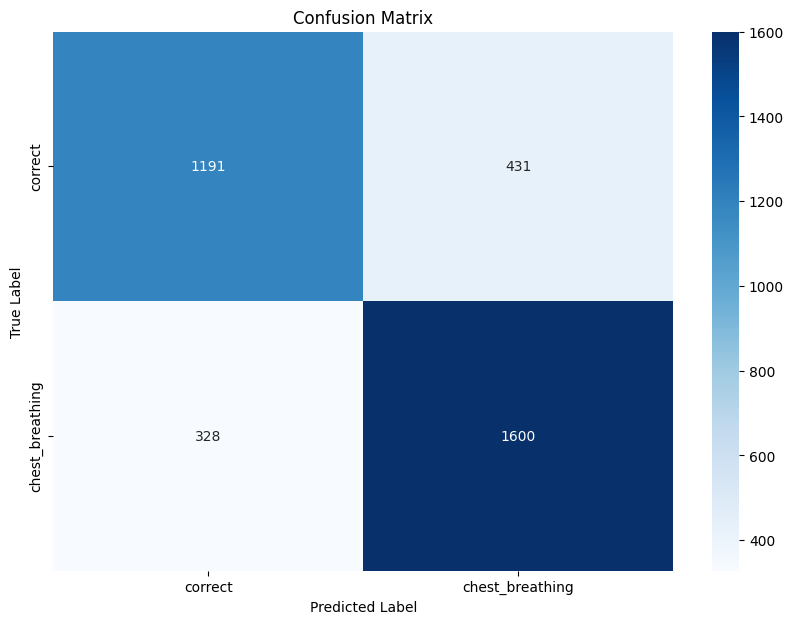

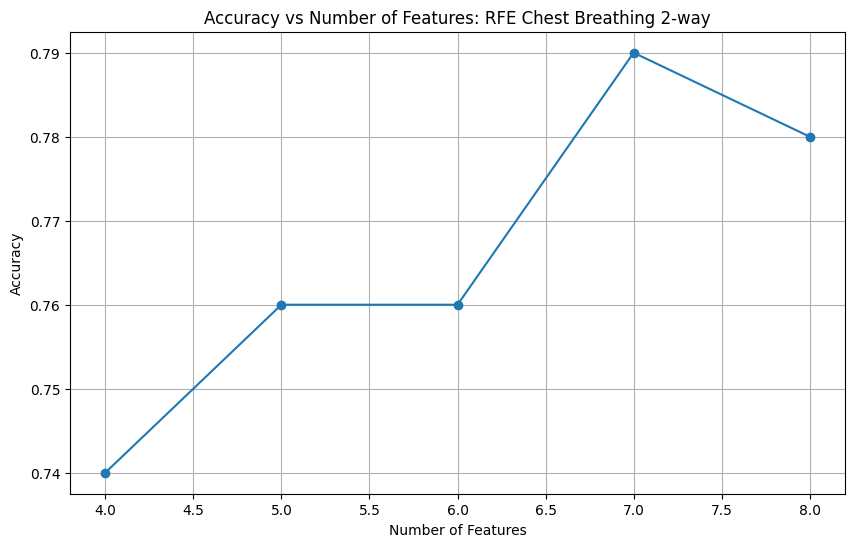

Number of features: 5
Selected Features:
['computer_pitch', 'computer_spec_slope', 'computer_tristimulus3', 'computer_mfcc_3', 'computer_mfcc_4']
Accuracy: 0.76
Classification Report:
                 precision    recall  f1-score   support

        correct       0.75      0.72      0.74      1622
chest_breathing       0.77      0.80      0.79      1928

       accuracy                           0.76      3550
      macro avg       0.76      0.76      0.76      3550
   weighted avg       0.76      0.76      0.76      3550



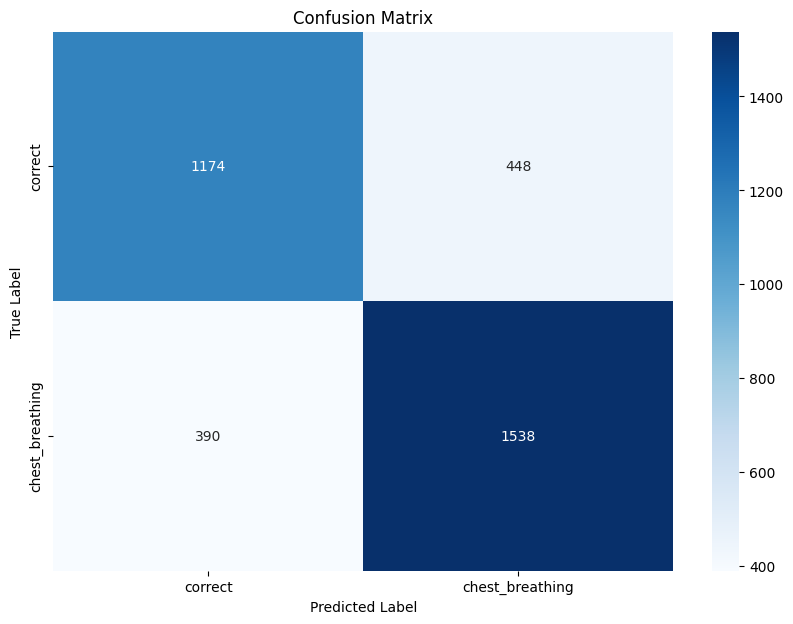

time: 909 ms (started: 2024-08-17 14:58:10 +00:00)


In [ ]:
results_file_path = '/content/drive/My Drive/THESIS/classifiers/data/rfe_chest_results_p9.json'
plot_results(results_file_path=results_file_path, class_names=class_names, algorithm='RFE Chest Breathing 2-way')
plot_results_for_num_features(results_file_path=results_file_path, class_names=class_names, algorithm='RFE 2-way Chest Breathing')